<a href="https://colab.research.google.com/github/deborahchang/projects/blob/Mortality_Project/outcome_regression_Data_102_Final_Project_Causal_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
import numpy as np
from sklearn.linear_model import LinearRegression
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/Mortality - Data 102/In_hospital_mortality.csv' # please change to 'In_hospital_mortality.csv'
mortality = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
import graphviz

dag_diabetes_bmi_age = graphviz.Digraph('DAG_diabetes_bmi_age', format='png')
dag_diabetes_bmi_age.node('Diabetes')
dag_diabetes_bmi_age.node('BMI')
dag_diabetes_bmi_age.node('Age, Gender, Blood Pressure etc.')


dag_diabetes_bmi_age.edge('Age, Gender, Blood Pressure etc.', 'Diabetes')
dag_diabetes_bmi_age.edge('Age, Gender, Blood Pressure etc.', 'BMI')
dag_diabetes_bmi_age.edge('Diabetes', 'BMI')
dag_diabetes_bmi_age.render(filename='dag_diabetes_bmi_age', format='png', cleanup=True)

print("DAG created and saved as 'dag_diabetes_bmi_age.png'")

DAG created and saved as 'dag_diabetes_bmi_age.png'


In [ ]:
outcome_regression_data = mortality[['age', 'gendera', 'BMI', 'hypertensive', 'Systolic blood pressure', 'Diastolic blood pressure',
               'Respiratory rate', 'diabetes', 'glucose', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD']].dropna()
covariates = ['age', 'gendera', 'hypertensive', 'Systolic blood pressure', 'Diastolic blood pressure',
               'Respiratory rate', 'diabetes', 'glucose', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD']

X = sm.add_constant(outcome_regression_data[covariates])
y = outcome_regression_data['BMI']

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     16.58
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           2.30e-32
Time:                        18:29:24   Log-Likelihood:                -3372.6
No. Observations:                 948   AIC:                             6771.
Df Residuals:                     935   BIC:                             6834.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

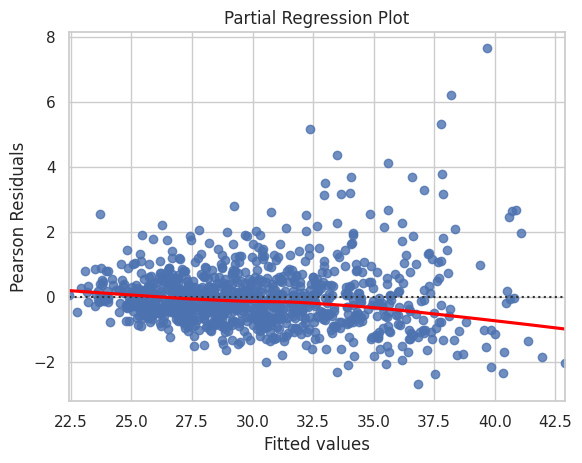

In [ ]:
# check for model assumption

X_const = sm.add_constant(X)
model = sm.OLS(y, X_const)
result = model.fit()

sns.set(style="whitegrid")
sns.residplot(x=result.predict(), y=result.resid_pearson, lowess=True, line_kws={'color': 'red'})
plt.title("Partial Regression Plot")
plt.xlabel("Fitted values")
plt.ylabel("Pearson Residuals")
plt.show()

In [ ]:
# IPW

treatment_group = outcome_regression_data[outcome_regression_data['diabetes'] == 1].copy()
control_group = outcome_regression_data[outcome_regression_data['diabetes'] == 0].copy()

combined_data = pd.concat([treatment_group, control_group])

cov_new = ['age', 'gendera', 'hypertensive', 'Systolic blood pressure', 'Diastolic blood pressure',
               'Respiratory rate', 'glucose', 'depression', 'Hyperlipemia', 'Renal failure', 'COPD']
X_propensity = combined_data[cov_new]
y_propensity = combined_data['diabetes']

propensity_model = LogisticRegression() # use logistic regression to predict propensity score
propensity_model.fit(X_propensity, y_propensity)

treatment_group['propensity_score'] = propensity_model.predict_proba(treatment_group[cov_new])[:, 1]
control_group['propensity_score'] = propensity_model.predict_proba(control_group[cov_new])[:, 1]

treatment_group['weight'] = 1 / treatment_group['propensity_score']
control_group['weight'] = 1 / (1 - control_group['propensity_score'])

weighted_data = pd.concat([treatment_group, control_group])

X_weighted = sm.add_constant(weighted_data[covariates])
y_weighted = weighted_data['BMI']

weighted_model = sm.WLS(y_weighted, X_weighted, weights=weighted_data['weight'])
result = weighted_model.fit()
print(result.summary())

                            WLS Regression Results                            
Dep. Variable:                    BMI   R-squared:                       0.163
Model:                            WLS   Adj. R-squared:                  0.153
Method:                 Least Squares   F-statistic:                     15.23
Date:                Mon, 11 Dec 2023   Prob (F-statistic):           1.37e-29
Time:                        18:29:26   Log-Likelihood:                -3410.1
No. Observations:                 948   AIC:                             6846.
Df Residuals:                     935   BIC:                             6909.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


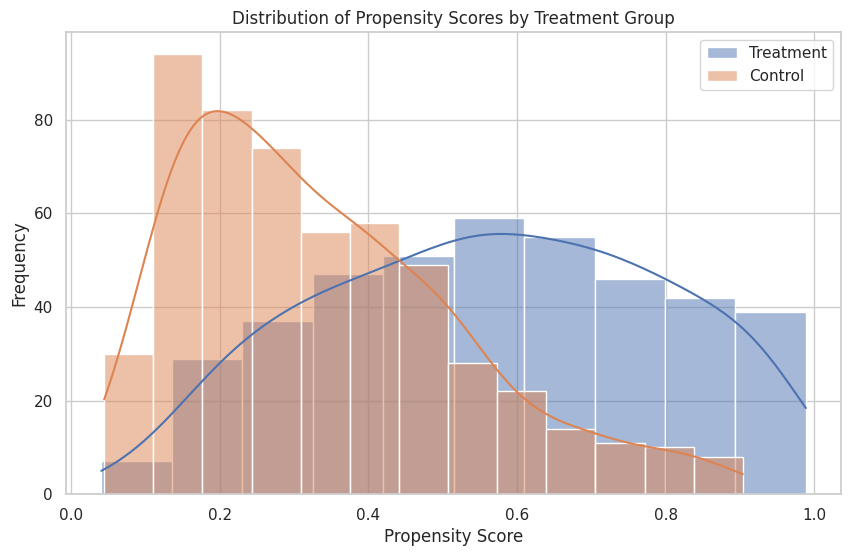

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(treatment_group['propensity_score'], label='Treatment', kde=True)
sns.histplot(control_group['propensity_score'], label='Control', kde=True)
plt.title('Distribution of Propensity Scores by Treatment Group')
plt.xlabel('Propensity Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

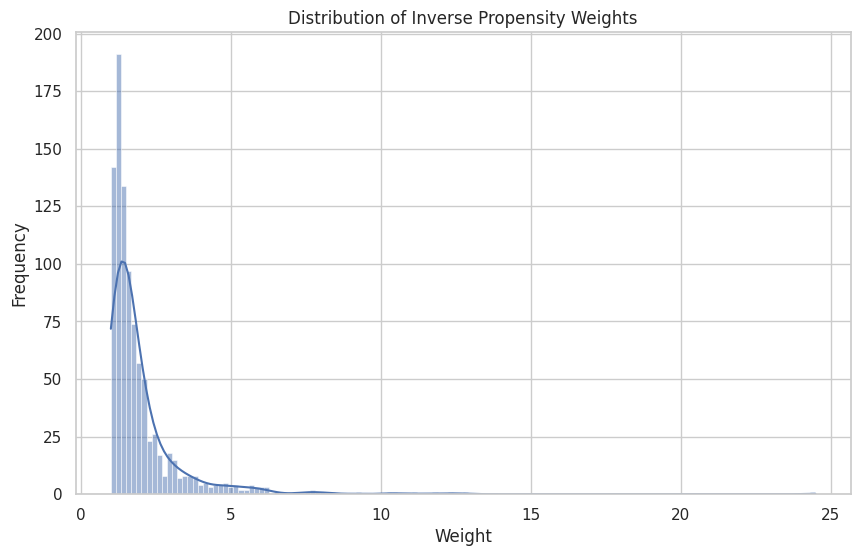

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(weighted_data['weight'], kde=True)
plt.title('Distribution of Inverse Propensity Weights')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()